# Machine Learning Model Development

The goal is to select and prototype suitable machine learning algorithms for predicting customer churn for a subscription-based telco service. This involves evaluating various models to identify the most effective approach for this specific churn prediction task.

## Initial Model Prototyping

Several models were prototyped to assess their suitability and performance for the churn prediction task. These models can be built using standard libraries with minimal effort. If the dataset and preprocessing required vary significantly from one model to another, resulting in considerable training effort, we must stick to theoretical concepts. This approach involves selecting a few ML algorithms well-suited for the task and limiting the number of models tried. But in this case following models were prototyped:


- [x] **Logistic Regression Model Prototyping**
- [x] **Random Forest Model Prototyping**
- [x] **XGBoost Model Prototyping**
- [x] **DNN Model Prototyping**
- [x] **CNN for Tabular Data Prototyping**

## Evaluation Metrics

For each prototyped model, several key metrics were considered to evaluate performance, including accuracy, precision, recall, and the confusion matrix. These metrics provide a comprehensive view of each model's strengths and weaknesses in predicting customer churn. Based on those metrics, the best models for Vertex AI Vizier hyperparameter tuning will be selected. 

In [1]:
import xgboost as xgb
import numpy as np

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
from tensorflow.math import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score,
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, auc
)

import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data = np.load('../data/dataset.npz')

# Extract the arrays for training, validation, and testing
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

In [3]:
def evaluate_model(model_name, y_true, y_pred, y_pred_proba=None):
    """
    Evaluate a model on various performance metrics.
    
    Parameters:
    - model_name: str. Name of the model being evaluated.
    - y_true: array-like. True labels.
    - y_pred: array-like. Predicted labels.
    - y_pred_proba: array-like (default None). Predicted probabilities for the positive class.
    
    Returns:
    - A dictionary with metric names as keys and their corresponding values.
    """
    metrics = {
        'Model': model_name,
        'Confusion Matrix': confusion_matrix(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'AUC-ROC': roc_auc_score(y_true, y_pred_proba) if y_pred_proba is not None else 'N/A',
        'AUC-PR': average_precision_score(y_true, y_pred_proba) if y_pred_proba is not None else 'N/A',
    }
    
    return metrics

In [4]:
def print_evaluation(metrics):
    """
    Prints the evaluation metrics from the evaluate_model function.
    """
    for key, value in metrics.items():
        if key != 'Model':
            print(f"{key}: {value}")
        else:
            print(f"{value} Evaluation")
    print("\n")  # New line for better readability between model evaluations

In [8]:
def plot_auc_curves(model_predictions, y_test):
    """
    Plot AUC-ROC and AUC-PR curves for multiple models.
    
    Parameters:
    - model_predictions: dict. A dictionary where keys are model names and 
                         values are dictionaries with keys 'y_pred_proba' and optionally 'label'.
    - y_test: array-like. True labels.
    """
    plt.figure(figsize=(14, 6))
    
    for model_name, preds in model_predictions.items():
        y_pred_proba = preds.get('y_pred_proba')
        label = preds.get('label', model_name)  # Use model name as label if not provided
        
        # AUC-ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, linewidth=2, label=f'{label} AUC-ROC = {roc_auc:.2f}')
        
        # AUC-PR Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = average_precision_score(y_test, y_pred_proba)
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, linewidth=2, label=f'{label} AUC-PR = {pr_auc:.2f}')
    
    # Finalizing AUC-ROC plot
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Chance Level')
    plt.scatter(0, 1, color='red', label='Perfect Performance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    
    # Finalizing AUC-PR plot
    plt.subplot(1, 2, 2)
    plt.plot([0, 1], [1, 1], color='red', linestyle='--', label='Perfect Performance')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall (PR) Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## LogisticRegression

In [5]:
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

In [6]:
lr_metrics = evaluate_model("Logistic Regression", y_test, y_pred_lr, y_pred_proba_lr)
print_evaluation(lr_metrics)

Logistic Regression Evaluation
Confusion Matrix: [[353 152]
 [ 41 158]]
Precision: 0.5096774193548387
Recall: 0.7939698492462312
Accuracy: 0.7258522727272727
F1-Score: 0.6208251473477406
AUC-ROC: 0.8139608935767948
AUC-PR: 0.6479686897345432




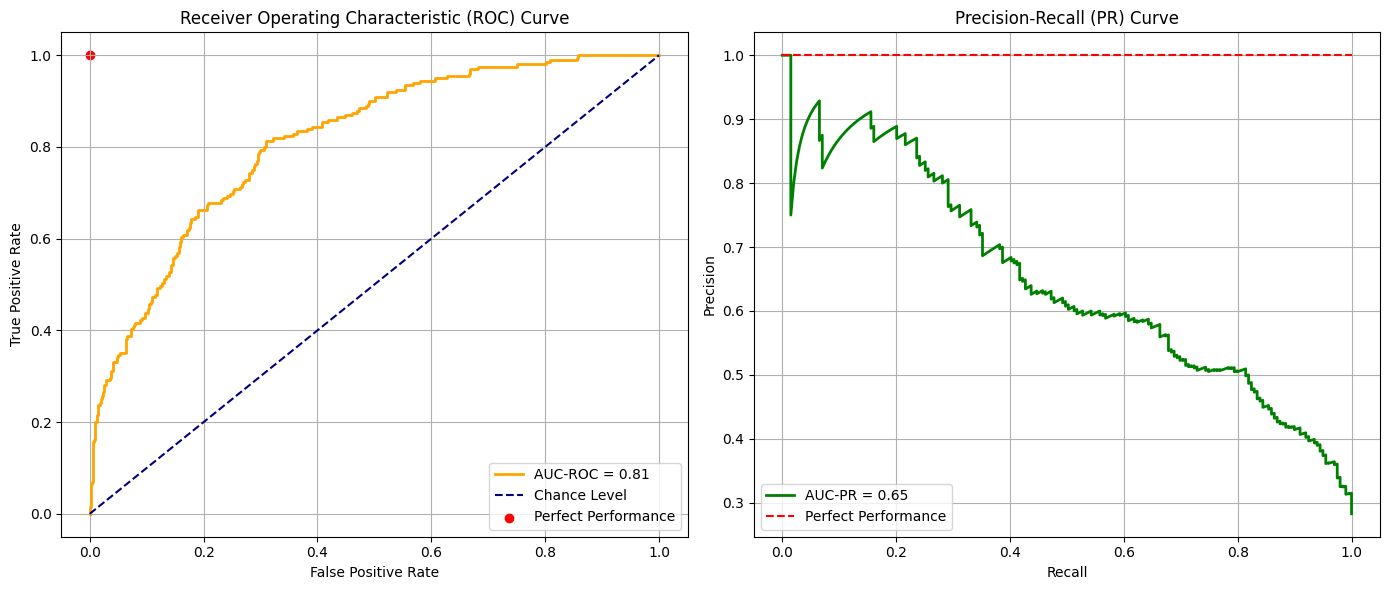

In [4]:
# Plotting
# AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='orange', label=f'AUC-ROC = {roc_auc:.2f}', linewidth=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Chance Level')
plt.scatter(0, 1, color='red', label='Perfect Performance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# AUC-PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_lr)
pr_auc = auc(recall, precision)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label=f'AUC-PR = {pr_auc:.2f}', linewidth=2)
plt.plot([0, 1], [1, 1], color='red', linestyle='--', label='Perfect Performance')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.show()

## RandomForestClassifier

In [9]:
# Adjusting for class imbalance
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predictions using probabilities for AUC calculations
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

In [10]:
rf_metrics = evaluate_model("Logistic Regression", y_test, y_pred_rf, y_pred_proba_rf)
print_evaluation(rf_metrics)

Logistic Regression Evaluation
Confusion Matrix: [[445  60]
 [110  89]]
Precision: 0.5973154362416108
Recall: 0.4472361809045226
Accuracy: 0.7585227272727273
F1-Score: 0.5114942528735633
AUC-ROC: 0.801084631076173
AUC-PR: 0.6100319827966554




In [5]:
# Adjusting for class imbalance
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predictions using probabilities for AUC calculations
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Evaluation
print("Random Forest Evaluation")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1-Score:", f1_score(y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba_rf))
print("AUC-PR:", average_precision_score(y_test, y_pred_proba_rf))

Random Forest Evaluation
Confusion Matrix:
 [[448  57]
 [110  89]]
Precision: 0.6095890410958904
Recall: 0.4472361809045226
Accuracy: 0.7627840909090909
F1-Score: 0.5159420289855072
AUC-ROC: 0.7970247275983879
AUC-PR: 0.6020972515315086


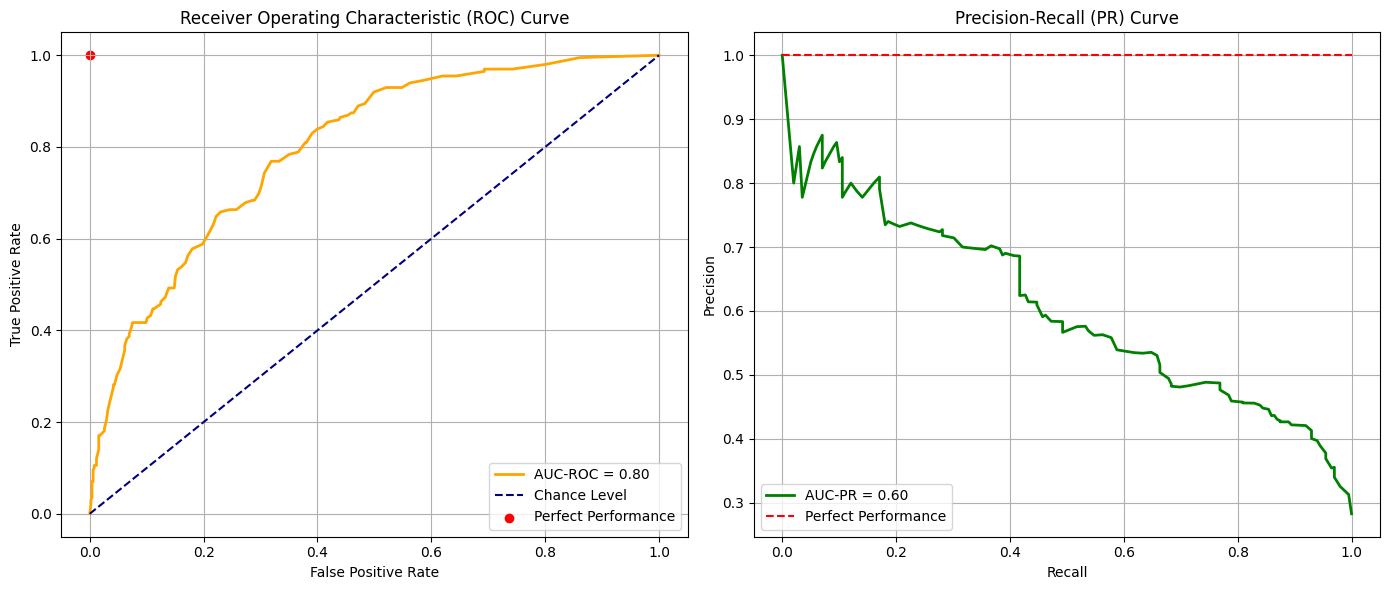

In [6]:
# Plot AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc = auc(fpr, tpr)  # Calculate the Area Under the Curve

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='orange', label=f'AUC-ROC = {roc_auc:.2f}', linewidth=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Chance Level')
plt.scatter(0, 1, color='red', label='Perfect Performance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Plot AUC-PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_rf)
pr_auc = auc(recall, precision)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label=f'AUC-PR = {pr_auc:.2f}', linewidth=2)
plt.plot([0, 1], [1, 1], color='red', linestyle='--', label='Perfect Performance')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.show()


## XGBoost

In [12]:
num_negative = np.sum(y_train == 0)
num_positive = np.sum(y_train == 1)
scale_pos_weight = num_negative / num_positive

# Convert the datasets into DMatrix objects, which is optimized for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for the XGBoost model
params = {
    'max_depth': 7,
    'eta': 0.09,
    'lambda': 8,
    'alpha': 0.3,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'scale_pos_weight': scale_pos_weight,
}

epochs = 300  # Number of epochs

# Train the model
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=epochs, evals=evals, early_stopping_rounds=5)


# Predictions on test set
y_pred_xgb = model.predict(dtest)
y_pred_binary_xgb = (y_pred_xgb > 0.5).astype(int)


[0]	train-aucpr:0.62126	eval-aucpr:0.56173
[1]	train-aucpr:0.67378	eval-aucpr:0.59008
[2]	train-aucpr:0.68044	eval-aucpr:0.61818
[3]	train-aucpr:0.68515	eval-aucpr:0.62852
[4]	train-aucpr:0.68853	eval-aucpr:0.63129
[5]	train-aucpr:0.69145	eval-aucpr:0.63573
[6]	train-aucpr:0.69770	eval-aucpr:0.63428
[7]	train-aucpr:0.69790	eval-aucpr:0.63553
[8]	train-aucpr:0.70585	eval-aucpr:0.64758
[9]	train-aucpr:0.70727	eval-aucpr:0.64826
[10]	train-aucpr:0.71469	eval-aucpr:0.64899
[11]	train-aucpr:0.71840	eval-aucpr:0.64541
[12]	train-aucpr:0.72384	eval-aucpr:0.64858
[13]	train-aucpr:0.72619	eval-aucpr:0.65110
[14]	train-aucpr:0.72945	eval-aucpr:0.65054
[15]	train-aucpr:0.73266	eval-aucpr:0.63811
[16]	train-aucpr:0.73585	eval-aucpr:0.63413
[17]	train-aucpr:0.73834	eval-aucpr:0.63811
[18]	train-aucpr:0.73863	eval-aucpr:0.64316


In [ ]:
xgb_metrics = evaluate_model("Logistic Regression", y_test, y_pred_xgb, y_pred_binary_xgb)
print_evaluation(xgb_metrics)

In [8]:
# Convert the datasets into DMatrix objects, which is optimized for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for the XGBoost model
params = {
    'max_depth': 7,
    'eta': 0.09,
    'lambda': 8,
    'alpha': 0.3,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'scale_pos_weight': scale_pos_weight,
}

epochs = 300  # Number of epochs

# Train the model
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=epochs, evals=evals, early_stopping_rounds=5)


# Predictions on test set
y_pred = model.predict(dtest)
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate the model
conf_mat = confusion_matrix(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc_roc = roc_auc_score(y_test, y_pred)
auc_pr = average_precision_score(y_test, y_pred)


print('Confusion Matrix:\n', conf_mat)
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'Accuracy: {accuracy:.5f}')
print(f'F1-Score: {f1:.5f}')
print(f'AUC-ROC: {auc_roc:.5f}')
print(f'AUC-PR: {auc_pr:.5f}')

[0]	train-aucpr:0.62126	eval-aucpr:0.56173
[1]	train-aucpr:0.67378	eval-aucpr:0.59008
[2]	train-aucpr:0.68044	eval-aucpr:0.61818
[3]	train-aucpr:0.68515	eval-aucpr:0.62852
[4]	train-aucpr:0.68853	eval-aucpr:0.63129
[5]	train-aucpr:0.69145	eval-aucpr:0.63573
[6]	train-aucpr:0.69770	eval-aucpr:0.63428
[7]	train-aucpr:0.69790	eval-aucpr:0.63553
[8]	train-aucpr:0.70585	eval-aucpr:0.64758
[9]	train-aucpr:0.70727	eval-aucpr:0.64826
[10]	train-aucpr:0.71469	eval-aucpr:0.64899
[11]	train-aucpr:0.71840	eval-aucpr:0.64541
[12]	train-aucpr:0.72384	eval-aucpr:0.64858
[13]	train-aucpr:0.72619	eval-aucpr:0.65110
[14]	train-aucpr:0.72945	eval-aucpr:0.65054
[15]	train-aucpr:0.73266	eval-aucpr:0.63811
[16]	train-aucpr:0.73585	eval-aucpr:0.63413
[17]	train-aucpr:0.73834	eval-aucpr:0.63811
[18]	train-aucpr:0.73863	eval-aucpr:0.64316
Confusion Matrix:
 [[351 154]
 [ 47 152]]
Precision: 0.49673
Recall: 0.76382
Accuracy: 0.71449
F1-Score: 0.60198
AUC-ROC: 0.81280
AUC-PR: 0.65687


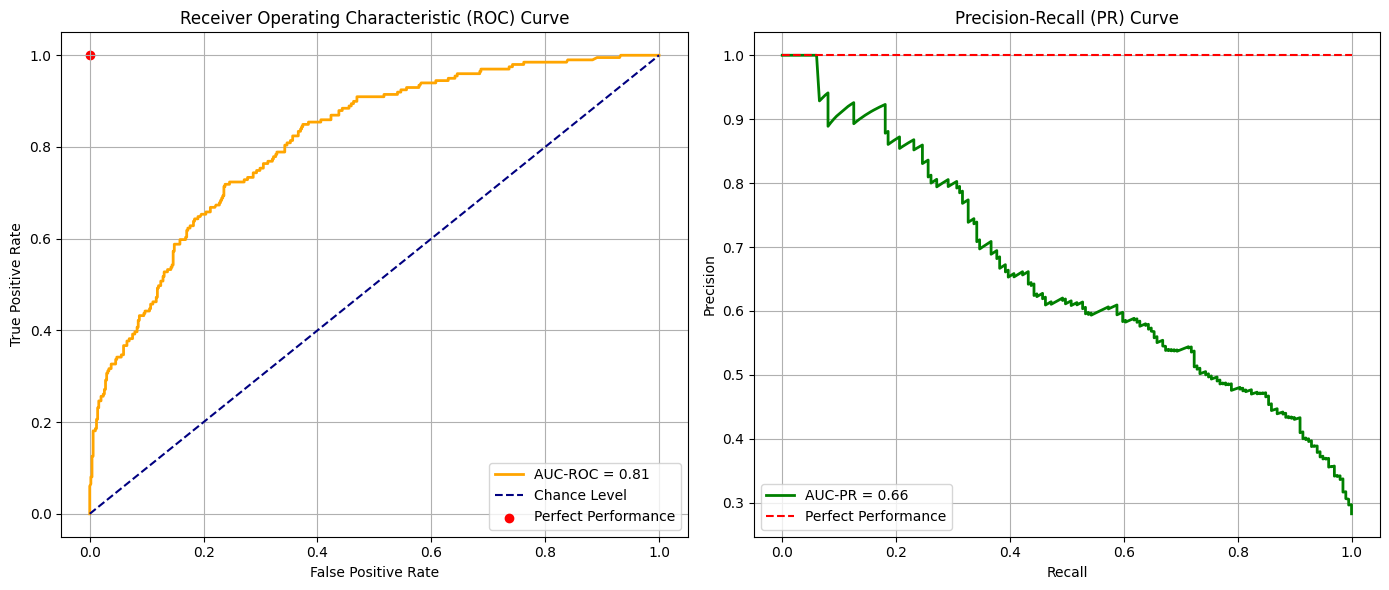

In [9]:
# Plot AUC-ROC Curve with improvements
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)  # Calculate the Area Under the Curve

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='orange', label=f'AUC-ROC = {roc_auc:.2f}', linewidth=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Chance Level')
plt.scatter(0, 1, color='red', label='Perfect Performance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Plot AUC-PR Curve with improvements
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)  # Calculate the Area Under the PR Curve

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label=f'AUC-PR = {pr_auc:.2f}', linewidth=2)
plt.plot([0, 1], [1, 1], color='red', linestyle='--', label='Perfect Performance')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.show()


## Vanilla Deep neural network (DNN)

In [10]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [11]:
# Define the DNN model with dropout layers
dnn_model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.5),  # Dropout layer after the first dense layer
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Another dropout layer after the second dense layer
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),  # Another dropout layer after the second dense layer
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, mode='min')

# Train the DNN model with early stopping and adaptive learning rate
# Use the class weights in model training
history = dnn_model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict  # Apply class weights
)


# Evaluate the DNN model
dnn_eval = dnn_model.evaluate(X_test, y_test)
print(f'DNN Test Loss: {dnn_eval[0]:.5f}')
print(f'DNN Test Accuracy: {dnn_eval[1]:.5f}')


Metal device set to: Apple M1 Pro
Epoch 1/100


2024-04-11 22:09:52.902711: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-11 22:09:52.902732: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-04-11 22:09:53.287000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - ETA: 0s - loss: 0.6286 - accuracy: 0.6213

2024-04-11 22:09:54.569500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 13ms/step - loss: 0.6286 - accuracy: 0.6213 - val_loss: 0.4966 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 2/100
88/88 [==============================] - 1s 9ms/step - loss: 0.5335 - accuracy: 0.7316 - val_loss: 0.4528 - val_accuracy: 0.7568 - lr: 0.0010
Epoch 3/100
88/88 [==============================] - 1s 8ms/step - loss: 0.5138 - accuracy: 0.7431 - val_loss: 0.4823 - val_accuracy: 0.7383 - lr: 0.0010
Epoch 4/100
88/88 [==============================] - 1s 8ms/step - loss: 0.5050 - accuracy: 0.7438 - val_loss: 0.4520 - val_accuracy: 0.7596 - lr: 0.0010
Epoch 5/100
88/88 [==============================] - 1s 8ms/step - loss: 0.5015 - accuracy: 0.7451 - val_loss: 0.4747 - val_accuracy: 0.7511 - lr: 0.0010
Epoch 6/100
88/88 [==============================] - 1s 8ms/step - loss: 0.4942 - accuracy: 0.7540 - val_loss: 0.4810 - val_accuracy: 0.7440 - lr: 0.0010
Epoch 7/100
88/88 [==============================] - 1s 8ms/step - loss: 0.4924 - accur

In [12]:
# Predictions on test set
y_pred_dnn = dnn_model.predict(X_test)
y_pred_dnn_binary = (y_pred_dnn > 0.5).astype(int)


# Evaluate the model
conf_mat = confusion_matrix(y_test, y_pred_dnn_binary)
precision = precision_score(y_test, y_pred_dnn_binary)
recall = recall_score(y_test, y_pred_dnn_binary)
accuracy = accuracy_score(y_test, y_pred_dnn_binary)
f1 = f1_score(y_test, y_pred_dnn_binary)
auc_roc = roc_auc_score(y_test, y_pred_dnn)
auc_pr = average_precision_score(y_test, y_pred_dnn)


print('Confusion Matrix:\n', conf_mat)
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'Accuracy: {accuracy:.5f}')
print(f'F1-Score: {f1:.5f}')
print(f'AUC-ROC: {auc_roc:.5f}')
print(f'AUC-PR: {auc_pr:.5f}')

22/22 [==============================] - 0s 2ms/step
Confusion Matrix:
 [[369 136]
 [ 53 146]]
Precision: 0.51773
Recall: 0.73367
Accuracy: 0.73153
F1-Score: 0.60707
AUC-ROC: 0.81380
AUC-PR: 0.64843


2024-04-11 22:10:04.148302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


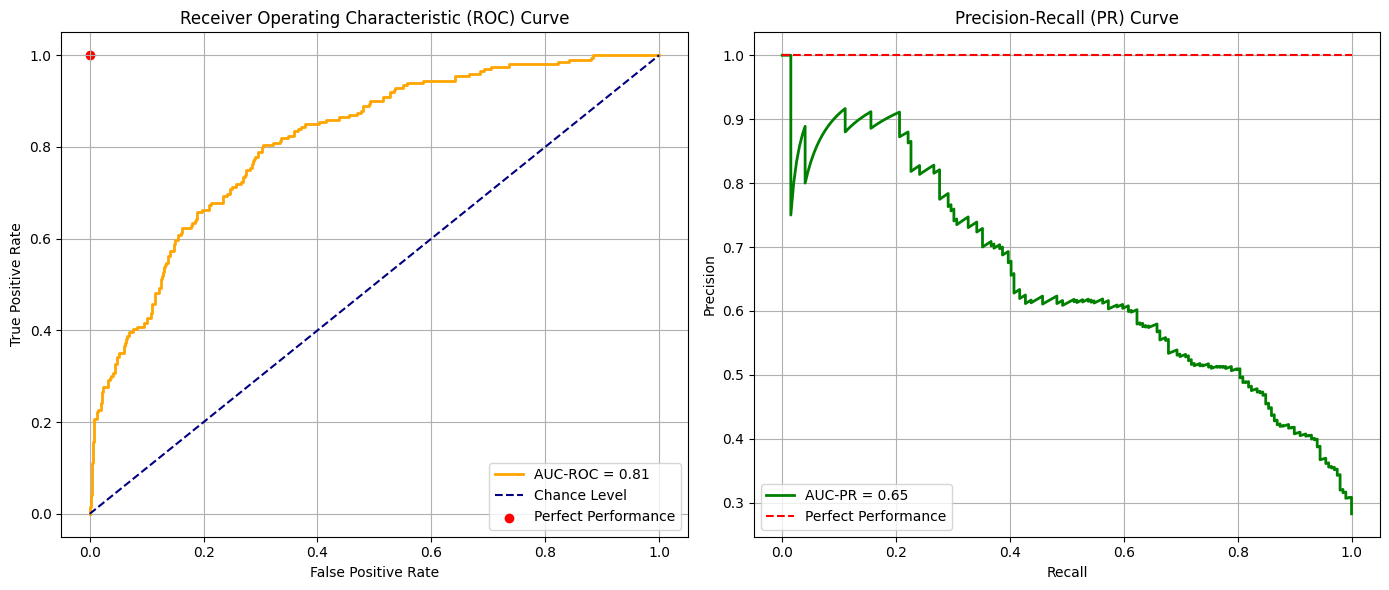

In [13]:
# Plot AUC-ROC Curve with improvements
fpr, tpr, thresholds = roc_curve(y_test, y_pred_dnn)
roc_auc = auc(fpr, tpr)  # Calculate the Area Under the Curve

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='orange', label=f'AUC-ROC = {roc_auc:.2f}', linewidth=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Chance Level')
plt.scatter(0, 1, color='red', label='Perfect Performance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Plot AUC-PR Curve with improvements
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_dnn)
pr_auc = auc(recall, precision)  # Calculate the Area Under the PR Curve

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label=f'AUC-PR = {pr_auc:.2f}', linewidth=2)
plt.plot([0, 1], [1, 1], color='red', linestyle='--', label='Perfect Performance')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.show()


## Convolutional Neural Networks (CNNs) for Tabular Data

In [14]:
# Reshape data: (number of samples, number of features, 1)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [15]:
def create_cnn_tabular_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout layer
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_tabular_model((X_train.shape[1], 1))


In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, mode='min')


history = cnn_model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    class_weight=class_weight_dict  # Apply class weights here
)

# Evaluate the CNN model
cnn_eval = cnn_model.evaluate(X_test_reshaped, y_test)
print(f'CNN Test Loss: {cnn_eval[0]:.5f}')
print(f'CNN Test Accuracy: {cnn_eval[1]:.5f}')

Epoch 1/100


2024-04-11 22:10:04.743142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - ETA: 0s - loss: 0.5435 - accuracy: 0.7180

2024-04-11 22:10:05.923262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 13ms/step - loss: 0.5435 - accuracy: 0.7180 - val_loss: 0.5587 - val_accuracy: 0.6956 - lr: 0.0010
Epoch 2/100
88/88 [==============================] - 1s 8ms/step - loss: 0.4999 - accuracy: 0.7335 - val_loss: 0.4955 - val_accuracy: 0.7283 - lr: 0.0010
Epoch 3/100
88/88 [==============================] - 1s 7ms/step - loss: 0.4960 - accuracy: 0.7419 - val_loss: 0.4737 - val_accuracy: 0.7539 - lr: 0.0010
Epoch 4/100
88/88 [==============================] - 1s 8ms/step - loss: 0.4849 - accuracy: 0.7532 - val_loss: 0.4805 - val_accuracy: 0.7340 - lr: 0.0010
Epoch 5/100
88/88 [==============================] - 1s 7ms/step - loss: 0.4865 - accuracy: 0.7445 - val_loss: 0.4386 - val_accuracy: 0.7838 - lr: 0.0010
Epoch 6/100
88/88 [==============================] - 1s 8ms/step - loss: 0.4874 - accuracy: 0.7465 - val_loss: 0.4682 - val_accuracy: 0.7596 - lr: 0.0010
Epoch 7/100
88/88 [==============================] - 1s 9ms/step - loss: 0.4827 - accur

In [17]:
# Predictions for further metrics calculation
y_pred_cnn = cnn_model.predict(X_test_reshaped)
y_pred_cnn_binary = (y_pred_cnn > 0.5).astype(int)

# Evaluate the model
conf_mat = confusion_matrix(y_test, y_pred_cnn_binary)
precision = precision_score(y_test, y_pred_cnn_binary)
recall = recall_score(y_test, y_pred_cnn_binary)
accuracy = accuracy_score(y_test, y_pred_cnn_binary)
f1 = f1_score(y_test, y_pred_cnn_binary)
auc_roc = roc_auc_score(y_test, y_pred_cnn)
auc_pr = average_precision_score(y_test, y_pred_cnn)

print('Confusion Matrix:\n', conf_mat)
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'Accuracy: {accuracy:.5f}')
print(f'F1-Score: {f1:.5f}')
print(f'AUC-ROC: {auc_roc:.5f}')
print(f'AUC-PR: {auc_pr:.5f}')

22/22 [==============================] - 0s 2ms/step
Confusion Matrix:
 [[380 125]
 [ 56 143]]
Precision: 0.53358
Recall: 0.71859
Accuracy: 0.74290
F1-Score: 0.61242
AUC-ROC: 0.81405
AUC-PR: 0.63811


2024-04-11 22:10:16.001974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


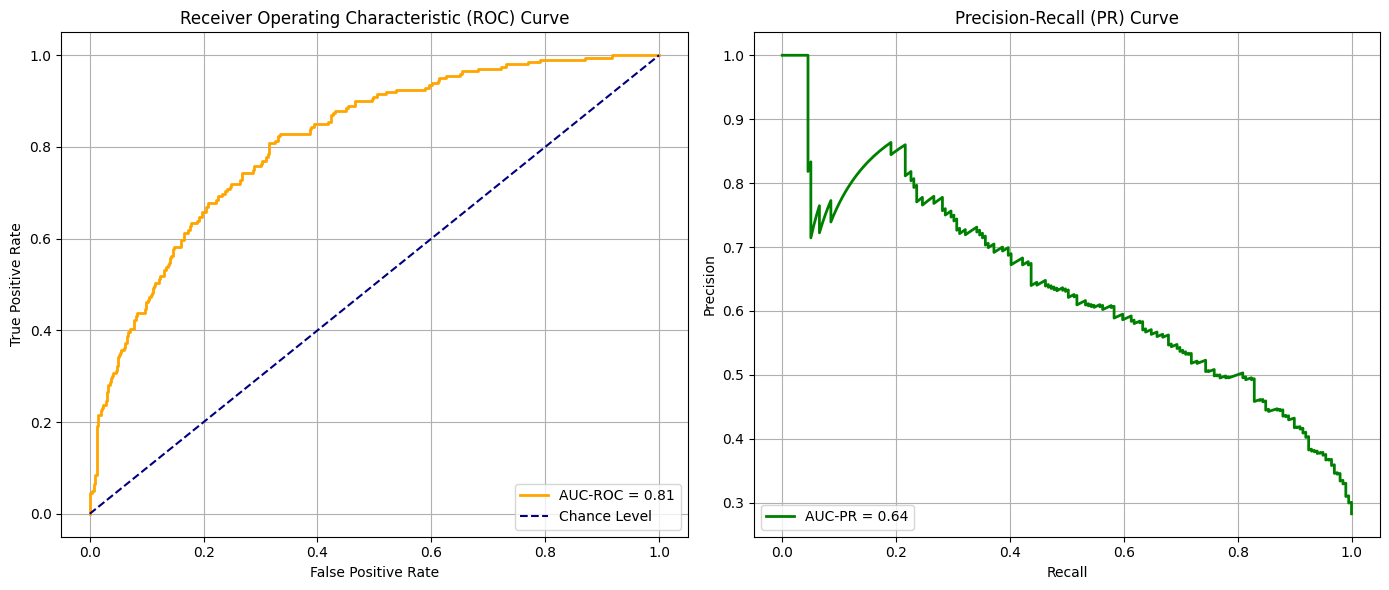

In [18]:
fpr, tpr, _ = roc_curve(y_test, y_pred_cnn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='orange', label=f'AUC-ROC = {roc_auc:.2f}', linewidth=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Chance Level')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# AUC-PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_cnn)
pr_auc = auc(recall, precision)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label=f'AUC-PR = {pr_auc:.2f}', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.show()

## ML Algorithm Selection

Based on the precision, recall, and accuracy from the model evaluation, it is clear that the XGBoost and DNN models perform slightly better than the other models. Therefore, these models were selected for extensive hyperparameter tuning using Vertex AI Vizier.


## Hyperparameter Tuning on Google Cloud Vertex AI

Considering the requirements of doing extensive optimal Hyperparameter search in the paramaters space with many trials it is benifites to use Vertex AI. 